# 1. Data Preparation


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt



# Define the allowed characters (26 lowercase + 26 uppercase)
ALPHABET = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
char_to_idx = {char: idx for idx, char in enumerate(ALPHABET)}

def one_hot_encode(letter):
    """Return a 52-dim one-hot vector for a given letter."""
    vec = np.zeros(len(ALPHABET), dtype=np.float32)
    if letter in char_to_idx:
        vec[char_to_idx[letter]] = 1.0
    return vec

class WordDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)  # CSV with columns: word, isEnlgish
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        word = str(row['word'])  # Convert to string in case it's a float
        label = float(row['isEnlgish'])  # 1 for English, 0 for Korean
        # Convert each character in the word to its one-hot representation
        word_seq = [one_hot_encode(ch) for ch in word if ch in char_to_idx]
        word_seq = torch.tensor(word_seq, dtype=torch.float32)  # shape: (seq_length, 52)
        label = torch.tensor([label], dtype=torch.float32)  # shape: (1,)
        return word_seq, label


In [3]:
import numpy  
print(numpy.__version__)


1.26.4


In [4]:
WordDataset('words.csv')[0]

/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_20569/3563031236.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/torch/csrc/utils/tensor_new.cpp:278.)
  word_seq = torch.tensor(word_seq, dtype=torch.float32)  # shape: (seq_length, 52)


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([0.]))

In [5]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    # Determine lengths of each sequence
    lengths = torch.tensor([seq.shape[0] for seq in sequences])
    # Pad sequences so they all have the same length (batch_first=True gives shape: (batch, max_length, 52))
    padded_seqs = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)  # shape: (batch, 1)
    return padded_seqs, labels, lengths


# 2. Model Definition


In [ ]:
class LanguageClassifier(nn.Module):
    def __init__(self, input_size=52, hidden_size=128, num_layers=1):
        super(LanguageClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, lengths):
        # Pack the padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (h_n, _) = self.lstm(packed)
        # h_n is of shape (num_layers, batch, hidden_size); we use the last layer’s hidden state
        h_last = h_n[-1]  # shape: (batch, hidden_size)
        out = self.fc(h_last)  # shape: (batch, 1)
        out = self.sigmoid(out)  # Output between 0 and 1
        return out


# 3. Training Loop


In [7]:
# Dataset and DataLoader
dataset = WordDataset("words.csv") # Replace 'words.csv' with your dataset path
# Calculate dataset sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
remaining_size = total_size - train_size
val_size = int(remaining_size / 2)
test_size = remaining_size - val_size


# Use random_split to create training, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn) # No need to shuffle val/test
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn) # No need to shuffle val/test


In [9]:
# --- Model, Criterion, Optimizer ---
model = LanguageClassifier(input_size=52, hidden_size=128, num_layers=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# 4. Bringing It All Together


Epoch 1, Training Loss: 0.3327, Validation Loss: 0.2123
Best model saved at epoch 1 with Validation Loss: 0.2123
Epoch 2, Training Loss: 0.1729, Validation Loss: 0.1542
Best model saved at epoch 2 with Validation Loss: 0.1542
Epoch 3, Training Loss: 0.1434, Validation Loss: 0.1401
Best model saved at epoch 3 with Validation Loss: 0.1401
Epoch 4, Training Loss: 0.1294, Validation Loss: 0.1213
Best model saved at epoch 4 with Validation Loss: 0.1213
Epoch 5, Training Loss: 0.1167, Validation Loss: 0.1314
Test Loss: 0.1203


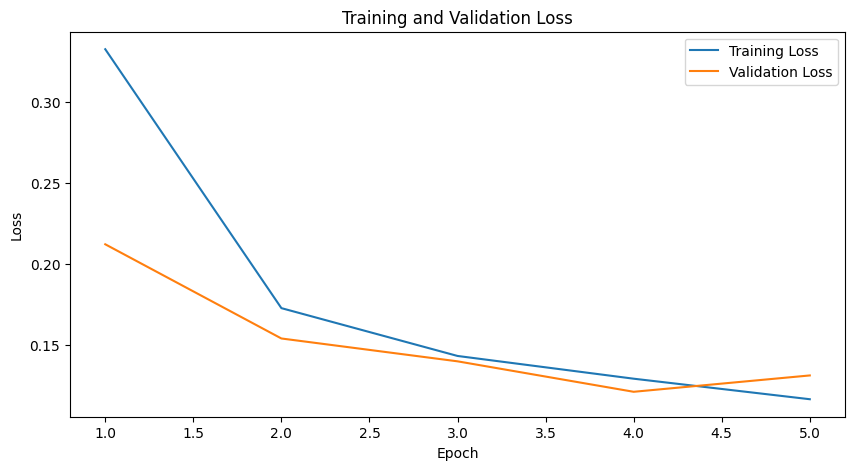

In [14]:
best_val_loss = float('inf')
train_losses = []
val_losses = []

# --- Training and Validation loop ---
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:  # Use train_dataloader
        inputs, labels, lengths = batch
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # --- Validation ---
    model.eval()  # Set model to evaluation mode for validation
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_dataloader:  # Use val_dataloader
            inputs, labels, lengths = batch
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # --- Save best model based on validation loss ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {best_val_loss:.4f}")

# --- Evaluation on Test set using the best model ---
# Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()  # Set model to evaluation mode for testing
test_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:  # Use test_dataloader
        inputs, labels, lengths = batch
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss:.4f}")

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [13]:
model.eval()
test_word = "am"
test_seq = [one_hot_encode(ch) for ch in test_word if ch in char_to_idx]
test_seq = torch.tensor(test_seq, dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_length, 52)
length = torch.tensor([len(test_seq[0])])
with torch.no_grad():
    prediction = model(test_seq, length)
print(f"Prediction for '{test_word}': {prediction.item():.4f}")

Prediction for 'am': 0.5054
